# North Sea climatology

This notebook presents the different steps necessary for the creation of a climatology:
1. ODV data reading.
2. Extraction of bathymetry and creation of mask
3. Data download from other sources and duplicate removal.
4. Quality control.
5. Parameter optimisation.
6. Spatio-temporal interpolation with `DIVAnd` [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.1466985.svg)](https://doi.org/10.5281/zenodo.1466985)

The notebook was tested with Julia 1.1.0 but should also work with previous versions.

In [1]:
using NCDatasets
using PhysOcean
using DataStructures
using DIVAnd
using PyPlot
using Dates
using Statistics
using Random
using JLD
using Printf

In [2]:
doplot = true

true

## Configuration
* Define the horizontal, vertical and temporal resolutions.
* Select the variable

In [3]:
dx, dy = 0.125, 0.125 # Resolution to modify
lonr = -4.0:dx:10.    
latr = 48.5:dy:62.  
timerange = [Date(1900,1,1),Date(2017,12,31)]; # Used when extracting the obs

depthr = Float64.([0.,5., 10., 15., 20., 25., 30., 35, 40., 45, 50., 55, 60, 65., 70, 
    75, 80, 85, 90, 95, 100, 125, 150, 175, 200, 225, 250, 
    275, 300, 325, 350, 375, 400, 425, 450, 475, 500, 550, 600, 650, 700]);

# For testing 
# depthr = Float64.([0.,5., 10., 15., 20.]);
# depthr = depthr[1:5]    # If you want to test on a few levels only

In [4]:
#varname = "Salinity"  
varname = "Temperature"

yearlist = [1955:2014]; 

# Annual
monthlist = [[1,2,3,4,5,6,7,8,9,10,11,12]];

# Seasonal
#monthlist = [[1,2,3],[4,5,6],[7,8,9],[10,11,12]]; 

#Monthly
#monthlist = [[i] for i = 1:12];    

In [5]:
TS = DIVAnd.TimeSelectorYearListMonthList(yearlist,monthlist);
@show TS;

TS = TimeSelectorYearListMonthList{Array{UnitRange{Int64},1},Array{Array{Int64,1},1}}(UnitRange{Int64}[1955:2014], Array{Int64,1}[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]])


## 1. Read your dataset
Adapt the `datadir` and `datafile` values.     
1. Download from [Sextant catalog](https://www.seadatanet.org/Products#/metadata/d9310aa6-c6b3-4657-a3c9-b0a4dd0f016c) (SeaDataCloud V1).
2. Export to ODV spreadsheet.
3. Export to netCDF.

The reading of the ODV spreadsheet is too long so we concentrate on the netCDF file generated by ODV.

### Reading from the netCDF generated by ODV
After the reading, we create a new file `obsfile` containing only the observations and the coordinates. To save time, this file has been stored on the cloud and can be downloaded.     
**Note:** standard_name attributes were added by hand ([NCO](http://nco.sourceforge.net/)) to the file with the following commands:
```bash
ncatted -O -a standard_name,longitude,o,c,longitude data_from_SDC_NS_DATA_DISCRETE_TS_V1.nc
ncatted -O -a standard_name,latitude,o,c,latitude data_from_SDC_NS_DATA_DISCRETE_TS_V1.nc
```

In [10]:
datadir = "/data/SeaDataCloud/NorthSea/"
figdir = "NorthSea/figures/"
obsfile = joinpath(datadir, "NorthSea_obs_$(varname)_sdn_wod_merged.nc")

"/data/SeaDataCloud/NorthSea/NorthSea_obs_Temperature_sdn_wod_merged.nc"

In [7]:
if !isfile(obsfile)
    #@info("Downloading observation file")
    #download("https://dox.ulg.ac.be/index.php/s/XG2G7CBDJ4RHvFN/download", netcdfODV)
    
    # If you want to generate it yourself: read the ODV netCDF, then save it
    
    if varname == "Salinity"
        @info "Reading salinity data"
        @time obsval, obslon, obslat, obsdepth, obstime, obsid = NCODV.load(Float64,
        netcdfODV, "Water body salinity");
    elseif varname == "Temperature"
        @time obsval, obslon, obslat, obsdepth, obstime, obsid = NCODV.load(Float64,
        netcdfODV, "ITS-90 water temperature");
    else
        @warn "Unknown variable"
    end
    
    
    @info("Writing the data and coordinates into an observation file")
    DIVAnd.saveobs(obsfile,varname,obsval,
                   (obslon, obslat, obsdepth, obstime),obsid)
    @info("Observations written in file $(obsfile)")
    
else
    @info("Observation file already there");
end

┌ Info: Reading data from the observation file
└ @ Main In[7]:1


 17.219350 seconds (32.93 M allocations: 8.309 GiB, 15.27% gc time)


┌ Info: Total number of data points: 8689894
└ @ Main In[7]:3


## Removing problematic data near the coast

In [12]:
sel2 = (obslon .> 5) .& (obslon .< 6.) .& (obslat .> 52.5) .& (obslat .< 53.3);
obsval2 = copy(obsval);
obsval2[sel2] .= mean(obsval[sel2]);

In [13]:
sel3 = (obslon .== 5.032299995422363) .& (obslat .== 53.052799224853516)
length(findall(sel3));
obsval3 = copy(obsval);
obsval3[sel3] .= mean(obsval3[sel3]);

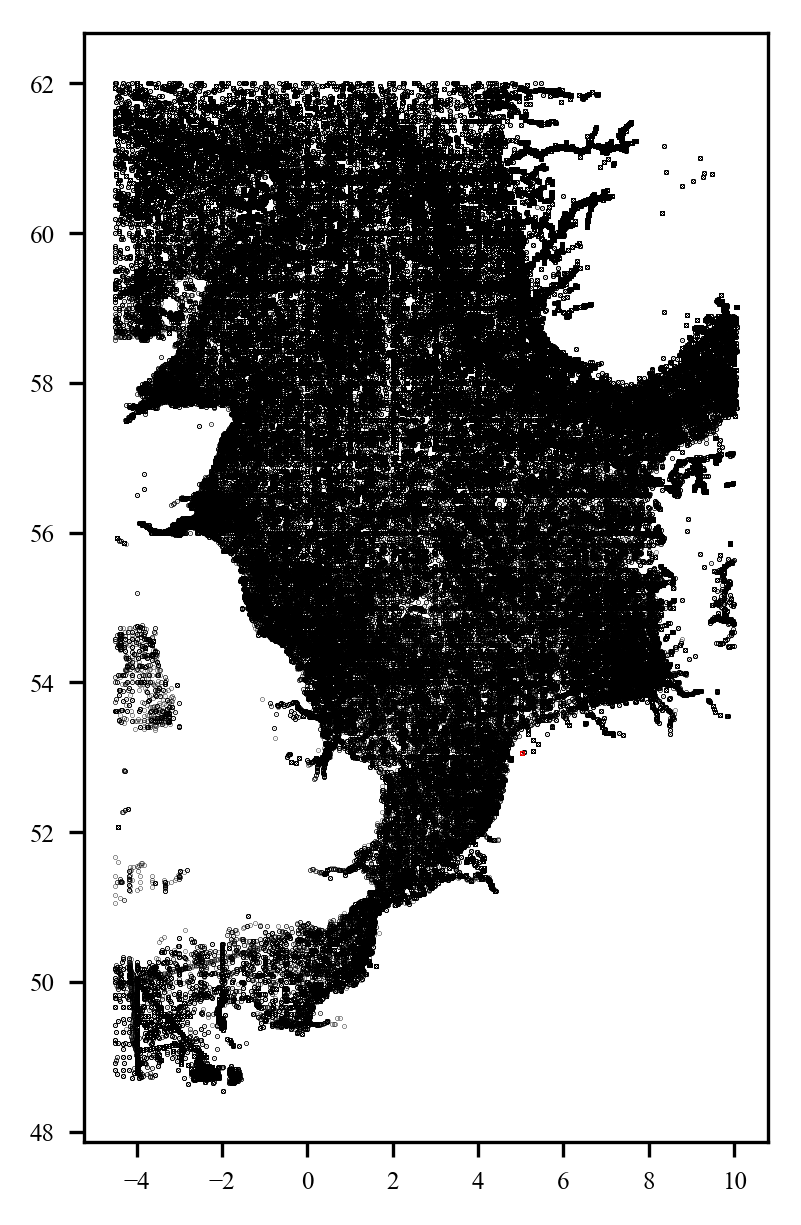

In [14]:
if doplot
    figure("NorthSea-Data")
    ax = subplot(1,1,1)
    plot(obslon, obslat, "ko", markersize=.1)
    plot(obslon[sel3], obslat[sel3], "ro", markersize=.1)
    aspect_ratio = 1/cos(mean(latr) * pi/180)
    ax.tick_params.("both",labelsize=6)
    gca().set_aspect(aspect_ratio)
    PyPlot.savefig(joinpath(figdir, "northsea_datapoints"), dpi=300, bbox_inches="tight")
end

Check the extremal values of the observations

In [15]:
checkobs((obslon,obslat,obsdepth,obstime),obsval,obsid)

┌ Info: Checking ranges for dimensions and observations
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/dM13X/src/obsstat.jl:75


              minimum and maximum of obs. dimension 1: (-4.5, 10.063799858093262)
              minimum and maximum of obs. dimension 2: (48.537498474121094, 62.0)
              minimum and maximum of obs. dimension 3: (0.0, 3000.0)
              minimum and maximum of obs. dimension 4: (1893-08-04T12:30:00, 2017-02-17T06:03:00)
                          minimum and maximum of data: (-2.0, 29.5)


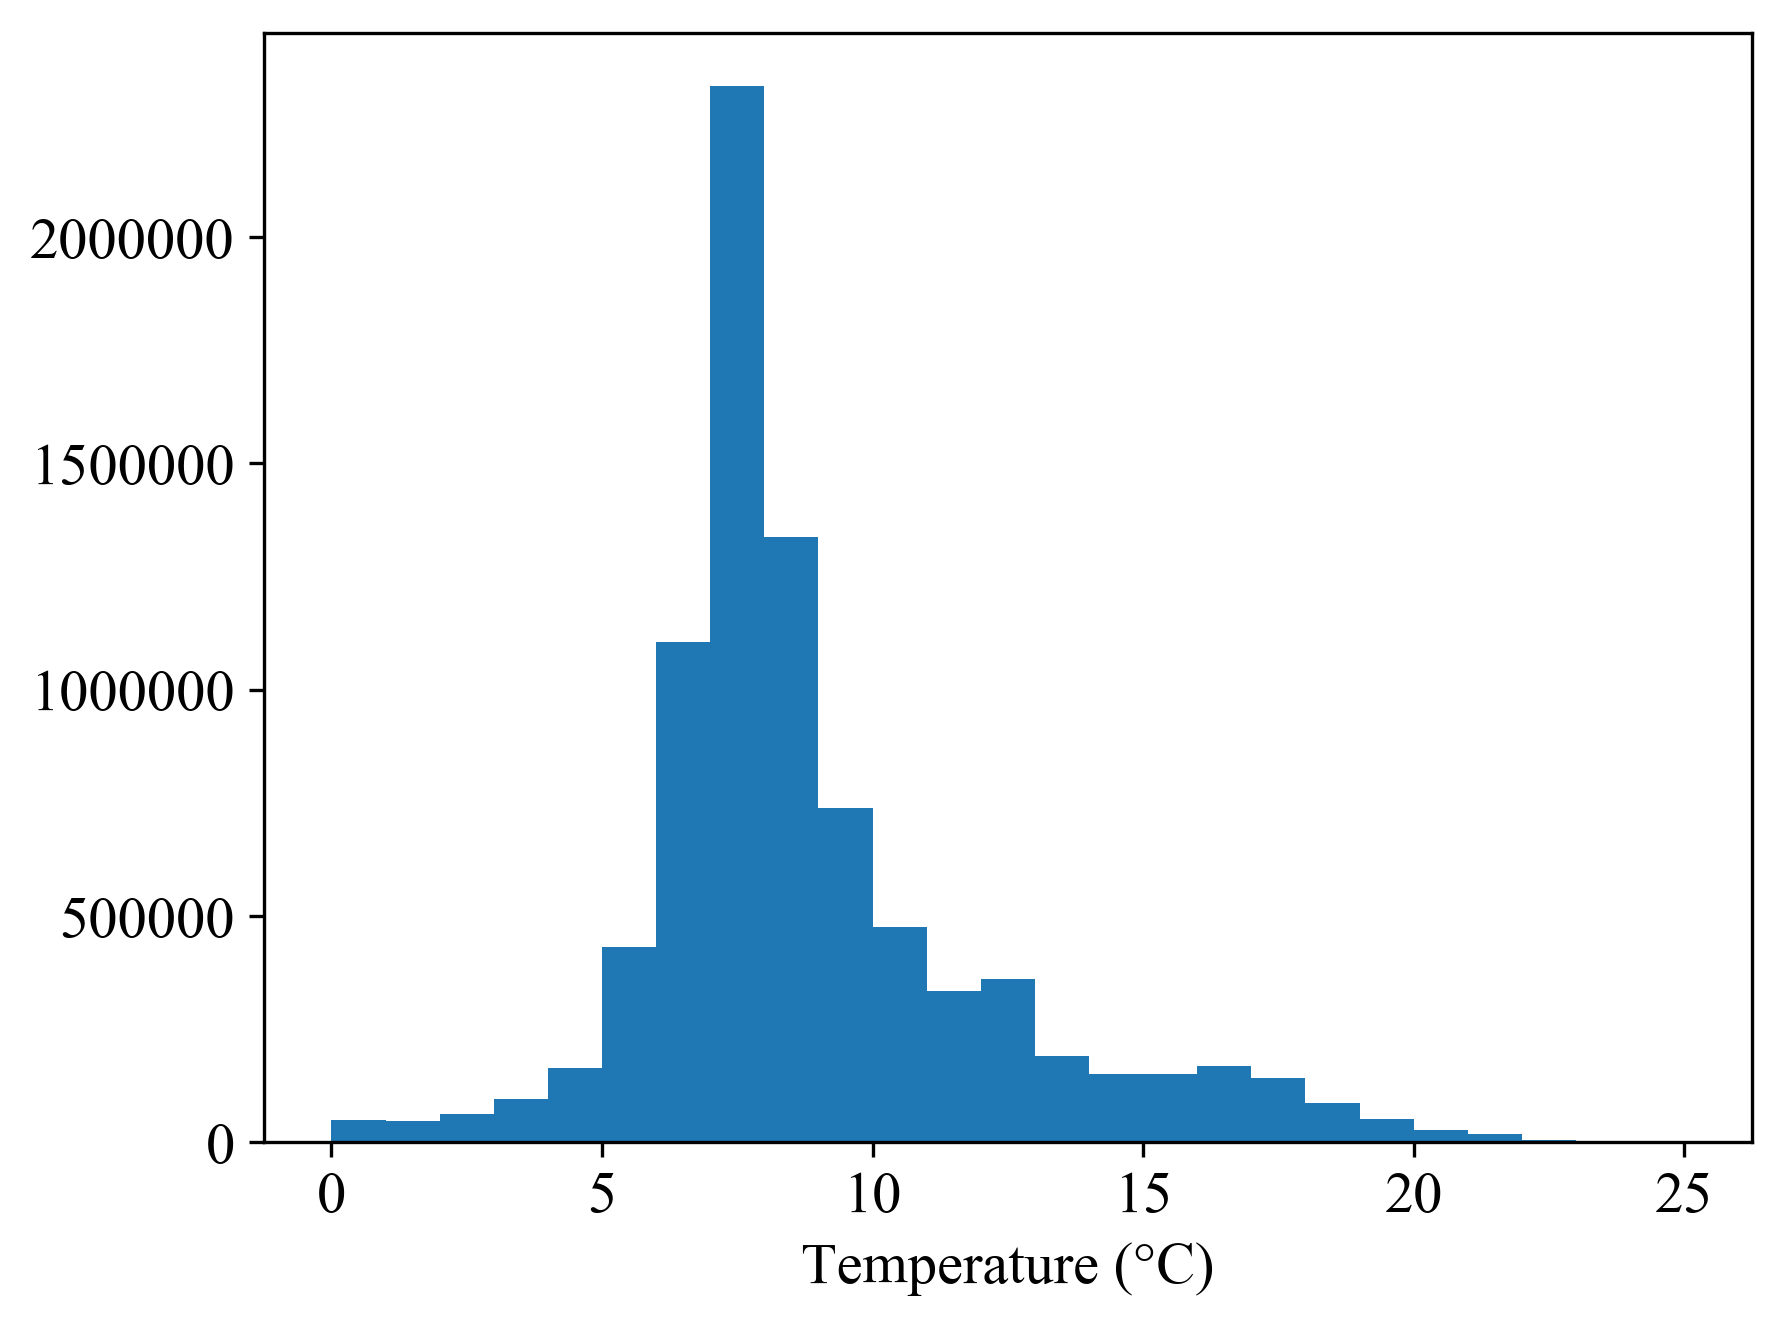

In [22]:
if doplot
    PyPlot.hist(obsval, 0:1:25);
    xlabel("Temperature (°C)")
    PyPlot.savefig(joinpath(figdir, "northsea_data_histogram"), dpi=300, bbox_inches="tight")
end

Check how many observations have a salinity above 38.

## 2. Extract the bathymetry
It is used to delimit the domain where the interpolation is performed.

### 2.1 Choice of bathymetry
Modify `bathname` according to the grid resolution (defined by `lonr` and `latr`) required.           
The different bathymetry are stored (if needed):      
https://dox.ulg.ac.be/index.php/s/RSwm4HPHImdZoQP/download →  gebco_30sec_4.nc      
https://dox.ulg.ac.be/index.php/s/wS6Y8P8NhIF60eG/download →  gebco_30sec_8.nc       
https://dox.ulg.ac.be/index.php/s/U0pqyXhcQrXjEUX/download →  gebco_30sec_16.nc      

### Testing the effect of the resolution

In [23]:
bathname = joinpath(datadir, "gebco_30sec_4.nc")
if !isfile(bathname)
    download("https://dox.ulg.ac.be/index.php/s/RSwm4HPHImdZoQP/download",bathname)
else
    @info("Bathymetry file already downloaded")
end

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  125M  100  125M    0     0  12.1M      0  0:00:10  0:00:10 --:--:-- 17.9M


"/data/SeaDataCloud/NorthSea/gebco_30sec_4.nc"

In [24]:
bathname2 = joinpath(datadir, "gebco_30sec_8.nc")
if !isfile(bathname2)
    download("https://dox.ulg.ac.bemaindex.php/s/wS6Y8P8NhIF60eG/download",bathname2)
else
    @info("Bathymetry file already downloaded")
end

┌ Info: Bathymetry file already downloaded
└ @ Main In[24]:5


In [25]:
bathname3 = joinpath(datadir, "gebco_30sec_16.nc")
if !isfile(bathname3)
    download("https://dox.ulg.ac.be/index.php/s/U0pqyXhcQrXjEUX/download",bathname3)
else
    @info("Bathymetry file already downloaded")
end

┌ Info: Bathymetry file already downloaded
└ @ Main In[25]:5


In [26]:
@time bx,by,b = load_bath(bathname,true,lonr,latr);
@time bx2,by2,b2 = load_bath(bathname2,true,lonr,latr);
@time bx3,by3,b3 = load_bath(bathname3,true,lonr,latr);

  4.247148 seconds (8.04 M allocations: 410.166 MiB)
  0.049121 seconds (285 allocations: 1.221 MiB)
  0.006047 seconds (284 allocations: 567.922 KiB)


### Plot for the comparison
A lower resolution helps to have smoother contours and less tiny islands or lakes that are not useful at our scale.

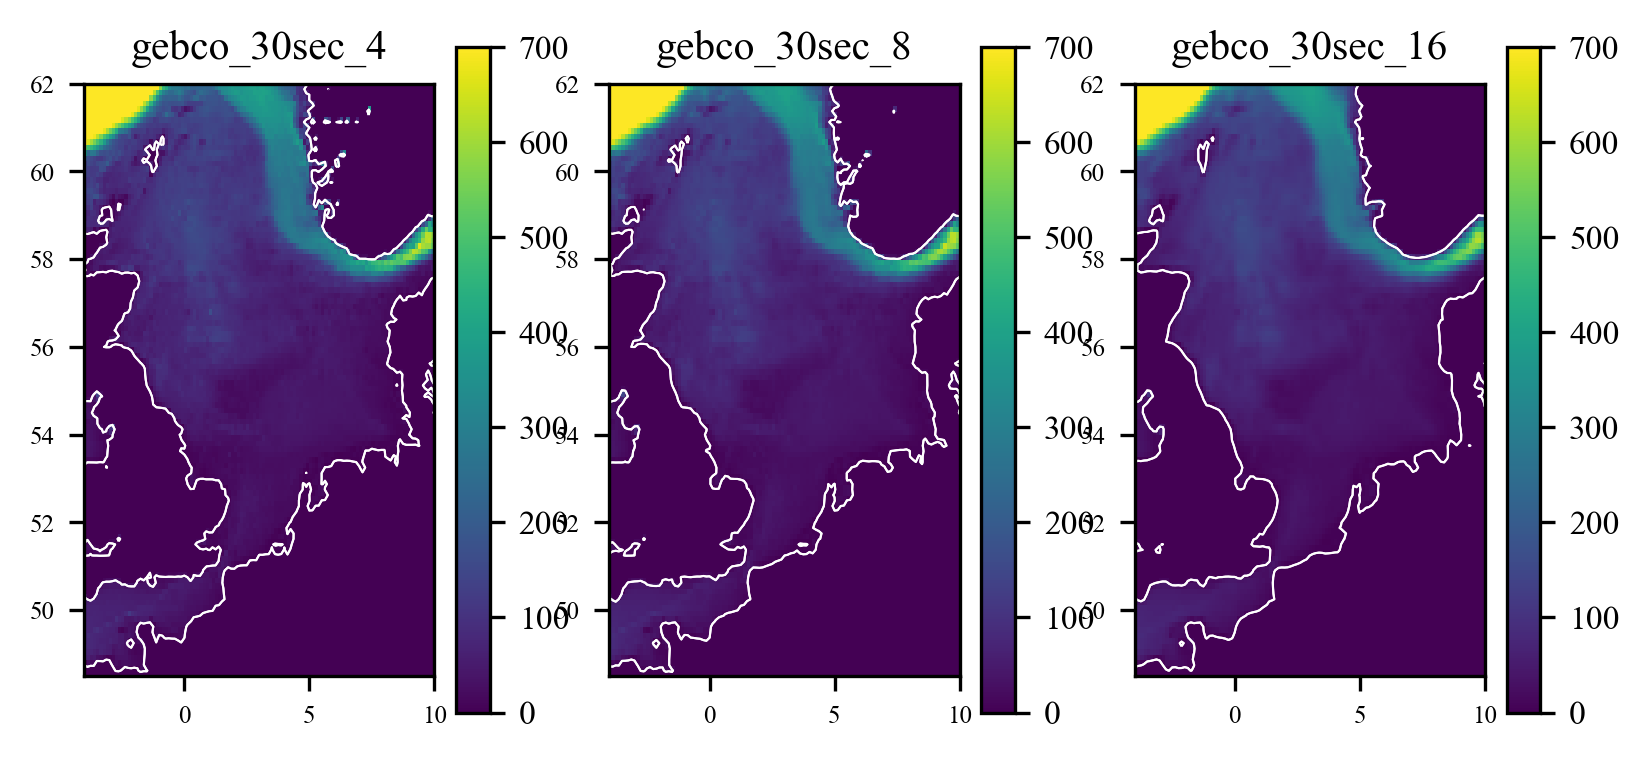

In [34]:
if doplot
    figure("NorthSea-Bathymetry")
    ax = subplot(1,3,1)
    pcolor(bx,by,permutedims(b, [2,1]), vmin=0., vmax=700.);
    colorbar(orientation="vertical", shrink=0.6).ax.tick_params(labelsize=8)
    contour(bx,by,permutedims(b, [2,1]), [0, 0.1], colors="w", linewidths=.5)
    gca().set_aspect(aspect_ratio)
    ax.tick_params("both",labelsize=6)
    title("gebco_30sec_4", fontsize=10)

    ax = subplot(1,3,2)
    pcolor(bx2,by2,permutedims(b2, [2,1]), vmin=0., vmax=700.);
    colorbar(orientation="vertical", shrink=0.6).ax.tick_params(labelsize=8)
    contour(bx2,by2,permutedims(b2, [2,1]), [0, 0.1], colors="w", linewidths=.5)
    gca().set_aspect(aspect_ratio)
    ax.tick_params("both",labelsize=6)
    title("gebco_30sec_8", fontsize=10)

    ax = subplot(1,3,3)
    pcolor(bx2,by2,permutedims(b3, [2,1]), vmin=0., vmax=700.);
    colorbar(orientation="vertical", shrink=0.6).ax.tick_params(labelsize=8)
    contour(bx2,by2,permutedims(b3, [2,1]), [0, 0.1], colors="w", linewidths=.5)
    gca().set_aspect(aspect_ratio)
    ax.tick_params("both",labelsize=6)
    title("gebco_30sec_16", fontsize=10)
    
    PyPlot.savefig(joinpath(figdir, "northsea_bathy_compare"), dpi=300, bbox_inches="tight")

end

### 2.2 Create mask
* False for sea        
* True for land

In [35]:
mask = falses(size(b,1),size(b,2),length(depthr))
for k = 1:length(depthr)
    for j = 1:size(b,2)
        for i = 1:size(b,1)
            mask[i,j,k] = b[i,j] >= depthr[k]
        end
    end
end
@show size(mask)

size(mask) = (113, 109, 41)


(113, 109, 41)

With the finer bathymetry:

In [36]:
mask2 = falses(size(b2,1),size(b2,2),length(depthr))
for k = 1:length(depthr)
    for j = 1:size(b2,2)
        for i = 1:size(b2,1)
            mask2[i,j,k] = b2[i,j] >= depthr[k]
        end
    end
end
@show size(mask2)

size(mask2) = (113, 109, 41)


(113, 109, 41)

In [37]:
mask3 = falses(size(b3,1),size(b3,2),length(depthr))
for k = 1:length(depthr)
    for j = 1:size(b3,2)
        for i = 1:size(b3,1)
            mask3[i,j,k] = b3[i,j] >= depthr[k]
        end
    end
end
@show size(mask3)

size(mask3) = (113, 109, 41)


(113, 109, 41)

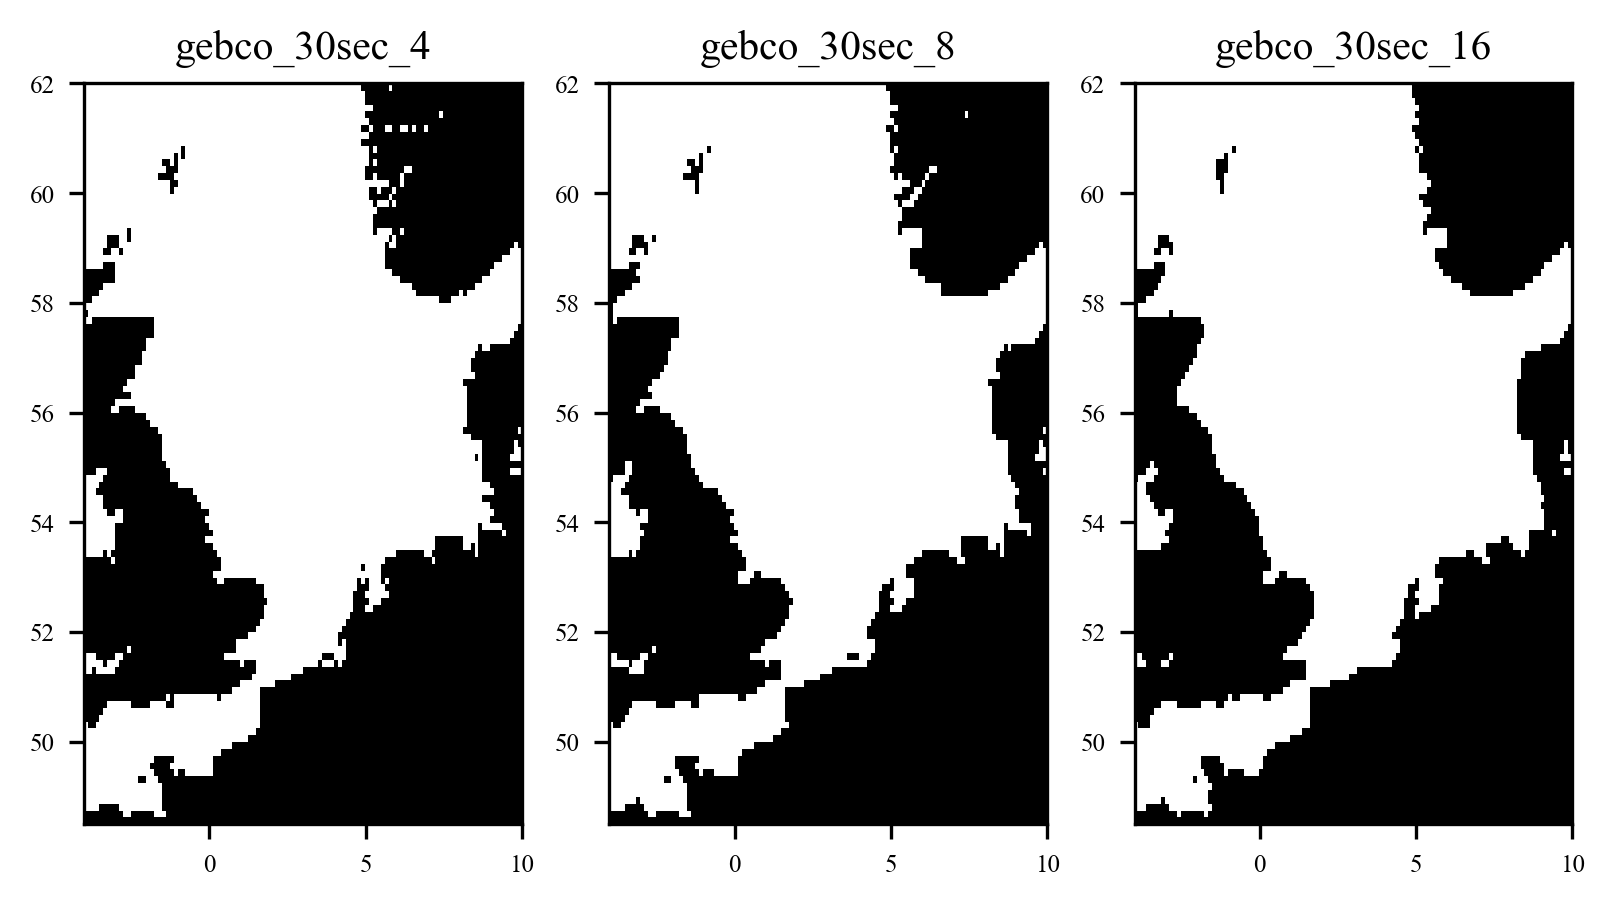

In [43]:
if doplot
    ax = subplot(1,3,1)
    pcolor(bx, by, permutedims(Float64.(mask[:,:,1]),[2,1]), cmap="binary_r"); 
    gca().set_aspect(aspect_ratio)
    ax.tick_params("both",labelsize=6)
    title("gebco_30sec_4", fontsize=10)
    
    ax = subplot(1,3,2)
    pcolor(bx2, by2, permutedims(Float64.(mask2[:,:,1]),[2,1]), cmap="binary_r");
    gca().set_aspect(aspect_ratio)
    ax.tick_params("both",labelsize=6)
    title("gebco_30sec_8", fontsize=10)
    
    ax = subplot(1,3,3)
    pcolor(bx3, by3, permutedims(Float64.(mask3[:,:,1]),[2,1]), cmap="binary_r");
    gca().set_aspect(aspect_ratio)
    ax.tick_params("both",labelsize=6)
    title("gebco_30sec_16", fontsize=10)
    
    PyPlot.savefig(joinpath(figdir, "northsea_mask_compare"), dpi=300, bbox_inches="tight")
    
end

## 5. Analysis parameters

### Modify data weight 
⌛⌛⌛       
Compute the new weights that takes into account close points.     
If the dataset is large, this can take a few minutes.     
The maximal and mean values provide an indication of the spatial proximity between the data.    
If you apply this technique, you need to adapt `epsilon2`:

We ran this computation in another script and saved the results in a `.jld` file.

In [23]:
weightfile = "./northsea_weights.jld"
w = load(weightfile);
rdiag = w["rdiag"];
@info length(rdiag);

┌ Info: 7680899
└ @ Main In[23]:4


In [24]:
#@time rdiag=1.0./DIVAnd.weight_RtimesOne((obslon,obslat),(0.03,0.03));
#@show maximum(rdiag),mean(rdiag)

### Correlation lengths and noise-to-signal ratio
We will use the function `diva3D` for the calculations.     
With this function, the correlation length has to be defined in meters, not in degrees.

In [45]:
sz = (length(lonr),length(latr),length(depthr));
lenx = fill(100_000.,sz)   # 100 km
leny = fill(100_000.,sz)   # 100 km
lenz = [min(max(30.,depthr[k]/150),300.) for i = 1:sz[1], j = 1:sz[2], k = 1:sz[3]]

len = (lenx, leny, lenz);
epsilon2 = 0.1;
# epsilon2 = epsilon2 * rdiag;

### Output file name

In [32]:
filename = "Water_body_$(replace(varname," "=>"_"))_NorthSea.4Danl_2REMOVE.nc"

"Water_body_Temperature_NorthSea.4Danl_2REMOVE.nc"

## 6. Metadata and attributes
Edit the different fields according to the project, the authors etc.     
This is used for the netCDF file but also for the XML needed for the Sextant catalog.

In [27]:
# ---------------
# TEMPERATURE!!!
# ---------------

if varname == "Temperature"
    
    metadata = OrderedDict(
        # Name of the project (SeaDataCloud, SeaDataNet, EMODNET-chemistry, ...)
        "project" => "SeaDataCloud",

        # URN code for the institution EDMO registry,
        # e.g. SDN:EDMO::1579
        "institution_urn" => "SDN:EDMO::3330",

        # Production group
        "production" => "DIVA group",

        # Name and emails from authors
        "Author_e-mail" => ["Serge Scory <sscory@naturalsciences.be>"],

        # Source of the observation
        "source" => "Observational data from SeaDataNet",

        # Additional comment
        "comment" => "Only one dataset considered (SeaDataCloud V1 discrete data)",

        # SeaDataNet Vocabulary P35 URN
        # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=p35
        # example: SDN:P35::WATERTEMP
        "parameter_keyword_urn" => "SDN:P35::WATERTEMP",

        # List of SeaDataNet Parameter Discovery Vocabulary P02 URNs
        # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=p02
        # example: ["SDN:P02::TEMP"]
        "search_keywords_urn" => ["SDN:P02::TEMP"],

        # List of SeaDataNet Vocabulary C19 area URNs
        # SeaVoX salt and fresh water body gazetteer (C19)
        # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=C19
        # example: ["SDN:C19::3_1"]
        "area_keywords_urn" => ["SDN:C19::1_2"],

        "product_version" => "1.0",

        "product_code" => "something-to-decide",

        # bathymetry source acknowledgement
        # see, e.g.
        # * EMODnet Bathymetry Consortium (2016): EMODnet Digital Bathymetry (DTM).
        # http://doi.org/10.12770/c7b53704-999d-4721-b1a3-04ec60c87238
        # 
        # taken from
        # http://www.emodnet-bathymetry.eu/data-products/acknowledgement-in-publications
        #
        # * The GEBCO Digital Atlas published by the British Oceanographic Data Centre on behalf of IOC and IHO, 2003
        #
        # taken from
        # https://www.bodc.ac.uk/projects/data_management/international/gebco/gebco_digital_atlas/copyright_and_attribution/

        "bathymetry_source" => "The GEBCO Digital Atlas published by the British Oceanographic Data Centre on behalf of IOC and IHO, 2003",

        # NetCDF CF standard name
        # http://cfconventions.org/Data/cf-standard-names/current/build/cf-standard-name-table.html
        # example "standard_name" = "sea_water_temperature",
        "netcdf_standard_name" => "sea_water_temperature",

        "netcdf_long_name" => "sea water temperature",

        "netcdf_units" => "degrees C",

        # Abstract for the product
        "abstract" => "...",

        # This option provides a place to acknowledge various types of support for the
        # project that produced the data
        "acknowledgement" => "...",

        "documentation" => "http://dx.doi.org/doi_of_doc",

        # Digital Object Identifier of the data product
        "doi" => "...");
end

OrderedDict{String,Any} with 19 entries:
  "project"               => "SeaDataCloud"
  "institution_urn"       => "SDN:EDMO::3330"
  "production"            => "DIVA group"
  "Author_e-mail"         => ["Serge Scory <sscory@naturalsciences.be>"]
  "source"                => "Observational data from SeaDataNet"
  "comment"               => "Only one dataset considered (SeaDataCloud V1 disc…
  "parameter_keyword_urn" => "SDN:P35::WATERTEMP"
  "search_keywords_urn"   => ["SDN:P02::TEMP"]
  "area_keywords_urn"     => ["SDN:C19::1_2"]
  "product_version"       => "1.0"
  "product_code"          => "something-to-decide"
  "bathymetry_source"     => "The GEBCO Digital Atlas published by the British …
  "netcdf_standard_name"  => "sea_water_temperature"
  "netcdf_long_name"      => "sea water temperature"
  "netcdf_units"          => "degrees C"
  "abstract"              => "..."
  "acknowledgement"       => "..."
  "documentation"         => "http://dx.doi.org/doi_of_doc"
  "doi"             

In [28]:
# ------------
# SALINITY !!!
# ------------

if varname == "Salinity"

    metadata = OrderedDict(
        # Name of the project (SeaDataCloud, SeaDataNet, EMODNET-chemistry, ...)
        "project" => "SeaDataCloud",

        # URN code for the institution EDMO registry,
        # e.g. SDN:EDMO::1579
        "institution_urn" => "SDN:EDMO::3330",

        # Production group
        "production" => "DIVA group",

        # Name and emails from authors
        "Author_e-mail" => ["Serge Scory <sscory@naturalsciences.be>"],

        # Source of the observation
        "source" => "Observational data from SeaDataNet",

        # Additional comment
        "comment" => "Only one dataset considered (SeaDataCloud V1 discrete data)",

        # SeaDataNet Vocabulary P35 URN
        # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=p35
        # example: SDN:P35::WATERTEMP
        "parameter_keyword_urn" => "SDN:P35::EPC00001",

        # List of SeaDataNet Parameter Discovery Vocabulary P02 URNs
        # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=p02
        # example: ["SDN:P02::TEMP"]
        "search_keywords_urn" => ["SDN:P02::PSAL"],

        # List of SeaDataNet Vocabulary C19 area URNs
        # SeaVoX salt and fresh water body gazetteer (C19)
        # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=C19
        # example: ["SDN:C19::3_1"]
        "area_keywords_urn" => ["SDN:C19::1_2"],

        "product_version" => "1.0",

        "product_code" => "something-to-decide",

        # bathymetry source acknowledgement
        # see, e.g.
        # * EMODnet Bathymetry Consortium (2016): EMODnet Digital Bathymetry (DTM).
        # http://doi.org/10.12770/c7b53704-999d-4721-b1a3-04ec60c87238
        # 
        # taken from
        # http://www.emodnet-bathymetry.eu/data-products/acknowledgement-in-publications
        #
        # * The GEBCO Digital Atlas published by the British Oceanographic Data Centre on behalf of IOC and IHO, 2003
        #
        # taken from
        # https://www.bodc.ac.uk/projects/data_management/international/gebco/gebco_digital_atlas/copyright_and_attribution/

        "bathymetry_source" => "The GEBCO Digital Atlas published by the British Oceanographic Data Centre on behalf of IOC and IHO, 2003",

        # NetCDF CF standard name
        # http://cfconventions.org/Data/cf-standard-names/current/build/cf-standard-name-table.html
        # example "standard_name" = "sea_water_temperature",
        "netcdf_standard_name" => "sea_water_salinity",

        "netcdf_long_name" => "sea water salinity",

        "netcdf_units" => "1e-3",

        # Abstract for the product
        "abstract" => "...",

        # This option provides a place to acknowledge various types of support for the
        # project that produced the data
        "acknowledgement" => "...",

        "documentation" => "http://dx.doi.org/doi_of_doc",

        # Digital Object Identifier of the data product
        "doi" => "...");
end

SeaDataNet global attributes:

In [31]:
ncglobalattrib,ncvarattrib = SDNMetadata(metadata,filename,varname,lonr,latr)

(OrderedDict("project"=>"SeaDataCloud","institution"=>"Royal Belgian Institute of Natural Sciences, Operational Directorate Natural Environment, Belgian Marine Data Centre","institution_urn"=>"SDN:EDMO::3330","production"=>"DIVA group","Author_e-mail"=>"Serge Scory <sscory@naturalsciences.be>","source"=>"Observational data from SeaDataNet","comment"=>"Only one dataset considered (SeaDataCloud V1 discrete data)","parameter_keyword"=>"ITS-90 water temperature","parameter_keyword_urn"=>"SDN:P35::WATERTEMP","search_keywords"=>"Temperature of the water column"…), OrderedDict("units"=>"degrees C","standard_name"=>"sea_water_temperature","long_name"=>"sea water temperature"))

## 7. Analysis

Remove the result file before running the analysis, otherwise you'll get the message     
```julia
NCDatasets.NetCDFError(13, "Permission denied")
```

In [33]:
if isfile(filename)
    rm(filename) # delete the previous analysis
    @info "Removing file $filename"
end

### 7.1 Plotting function
Define a plotting function that will be applied for each time index and depth level.     
All the figures will be saved in a selected directory.

In [34]:
figdir = "NorthSea/figures/rdiag/"
if ~(isdir(figdir))
    mkpath(figdir)
else
    @info("Figure directory already exists")
end

┌ Info: Figure directory already exists
└ @ Main In[34]:5


In [35]:
function plotres(timeindex,sel,fit,erri)
    @show timeindex
end

plotres (generic function with 1 method)

### 7.2 Create the gridded fields using `diva3d`
Here only the noise-to-signal ratio is estimated.     
Set `fitcorrlen` to `true` to also optimise the correlation length.

In [39]:
@time dbinfo = diva3d((lonr,latr,depthr,TS),
    (obslon,obslat,obsdepth,obstime), obsval2,
    len, epsilon2,
    filename,varname,
    bathname=bathname3,
    mask = mask3,
    fitcorrlen = false,
    niter_e = 2,
    ncvarattrib = ncvarattrib,
    ncglobalattrib = ncglobalattrib,
    MEMTOFIT=100,
    solver=:direct,
    surfextend = true
    );

┌ Info: Creating netCDF file
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/dM13X/src/diva.jl:318
┌ Info: Time step 1 / 1
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/dM13X/src/diva.jl:355
┌ Info: scaled correlation length (min,max) in dimension 1: (100000.0, 100000.0)
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/dM13X/src/diva.jl:500
┌ Info: scaled correlation length (min,max) in dimension 2: (100000.0, 100000.0)
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/dM13X/src/diva.jl:500
┌ Info: scaled correlation length (min,max) in dimension 3: (30.0, 30.0)
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/dM13X/src/diva.jl:500
┌ Warning: resolution (15.0) is too coarse for correlation length 30.0 in dimension 3 at indices CartesianIndex(42, 61, 22) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/dM13X/src/utils.jl:14
┌ Info: number of windows: 1
└ @ DIVAnd /ho

215.201373 seconds (444.10 k allocations: 63.386 GiB, 43.46% gc time)


In [44]:
nnans = findall(isnan.(dbinfo[:residuals]));
@info("Number of nans: $(length(nnans))");

┌ Info: Number of nans: 2390711
└ @ Main In[44]:2


Save the observation metadata in the NetCDF file.      
⚠️ The WOD observations IDs have to be modified in order to be ingested by the XML generation ([Step 9](http://localhost:8888/notebooks/90-full-analysis.ipynb#9.-XML-metadata)): to this end, we add the EDMO code of the [U.S. NODC](http://seadatanet.maris2.nl/v_edmo/print.asp?order=&step=003nodc_00043_0021&count=0&n_code=1977&page_size=50&markers_show=1&map=1&oldorder=name&desc=0), which is 1977.

In [52]:
obsidlist = copy(obsid);
for i in 1:length(obsidlist)
    if occursin("wod_", obsidlist[i])
        obsidlist[i] = replace(obsidlist[i], "wod_"=>"1977-wod_")
    end
end;

In [53]:
DIVAnd.saveobs(filename,(obslon,obslat,obsdepth,obstime),obsidlist);

## 8. Apply a posteriori quality control
We can use the structure `dbinfo`.
histogram for quality flags

## 9. XML metadata

For DIVAnd analysis using SeaDataCloud/EMODnet-Chemistry data, one can create a XML description for the product for Sextant

Name of the project:
* "SeaDataCloud" or 
* "EMODNET-chemistry"

In [ ]:
project = "SeaDataCloud";

Download CDI list

In [31]:
cdilist = "CDI-list-export.zip"

if !isfile(cdilist)
   download("http://emodnet-chemistry.maris2.nl/download/export.zip",cdilist)
end

If `ignore_errors` is `false` (default), then a missing CDI will stop the creatation of the XML metadata.

In [ ]:
ignore_errors = true

# File name based on the variable (but all spaces are replaced by underscores)
xmlfilename = "Water_body_$(replace(varname," "=>"_")).4Danl.xml"

Uncomment the following line of you are using SeaDataCloud or EMODnet-Chemistry data.

In [33]:
# generate a XML file for Sextant catalog
divadoxml(filename,varname,project,cdilist,xmlfilename,
          ignore_errors = ignore_errors)

UndefVarError: UndefVarError: ignore_errors not defined